# Extreme Value Anlaysis using daily Precipitation data from Cal-Adapt API with modified [wcarthur/extremes](https://github.com/wcarthur/extremes/tree/python) python code using [R eva](https://github.com/geekman1/eva_package/tree/master/R) package

In [1]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import genpareto
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate

import logging
LOG = logging.getLogger(__name__)

----
# Download data
----

Daily data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. Units for the observed data are mm and projected data are in kg/m2/s.

The code in the next cell contains a bunch of functions to:
    - fetch daily data given a slug and params
    - convert units to inches
    - return a new Pandas dataframe that contains all the data

In [2]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Request header
headers = {'ContentType': 'json'}

# Params
point = 'POINT(-121.4687 38.5938)'
params = {'g': point}

def mm_to_inches(val):
    return val * 0.0393701

def kgm2s_to_inches(val):
    return  (val * 86400) * 0.0393701

In [3]:
def process_daily_data(slug, params):
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        print('Processing:', slug)
        json = response.json()
        data = json['results'][0]

        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()

        # Get total number of values -> number of days
        length = len(values_arr)

        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')

        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index=pd.date_range(start_date, freq='1D', periods=length),
            columns=['value'],
        )

        # Convert units to Fahrenheit
        units = data['units']
        if units == 'mm':
            df.value = df.value.apply(lambda x: mm_to_inches(x))
        elif units == 'kg/m2/s':
            df.value = df.value.apply(lambda x: kgm2s_to_inches(x))
        else:
            pass
            
        # Add slug as a column
        df['series'] = slug.split('_')[2]
        
        # Add wateryear as a column
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['wateryear'] = np.where(df['month'] > 9, df['year'] + 1, df['year'])

    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

In [4]:
# Download observed daily timeseries
def get_observed():
    # Create slug
    slug = 'pr_day_livneh'
    df = process_daily_data(slug, params)
    return df

df = get_observed()
df

Processing: pr_day_livneh


,value,series,year,month,wateryear
1950-01-01,0.021879,livneh,1950,1,1950
1950-01-02,0.038984,livneh,1950,1,1950
1950-01-03,0.000000,livneh,1950,1,1950
1950-01-04,0.000000,livneh,1950,1,1950
1950-01-05,0.000000,livneh,1950,1,1950
1950-01-06,0.000000,livneh,1950,1,1950
1950-01-07,0.278853,livneh,1950,1,1950
1950-01-08,0.227935,livneh,1950,1,1950
1950-01-09,0.043757,livneh,1950,1,1950
1950-01-10,0.640446,livneh,1950,1,1950


----
# Select Threshold
----

Using a baseline period of wateryears 1961 - 1990, calculate the Annual Maximum Series (AMS) Precipitation for each year. The minimum value from AMS is selected as the threshold.

Threshold value =  0.6 inches


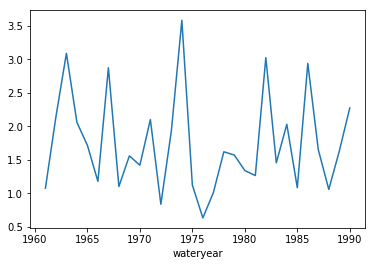

In [5]:
# Filter data by baseline time period
baselineDF = df.loc[(df['wateryear'] >= 1961) & (df['wateryear'] <= 1990) & (df['series'] == 'livneh')]
baselineDF_max = baselineDF.groupby('wateryear').value.max()
baselineDF_max.plot()

# Create an array of maximum values by water year
AMS = baselineDF_max.values

# Set threshold
threshold = round(np.min(AMS), 1)
print('Threshold value = ', threshold, 'inches')

----
# Extreme Value Analysis using Peak Over Threshold (PoK) method
----

Create Parital Duration Series (PDS)

In [6]:
PDS = baselineDF['value'].values
print('Number of observations =', len(PDS))
print('Number of exceedances =', (PDS > threshold).sum())

Number of observations = 10957
Number of exceedances = 286


Serial Correlation - If there is a group of back to back events, pick the maximum of that group and remove the remaining members of that group from the PDS

In [7]:
## TODO

Estimate fit parameters

In [8]:
def calculateShape(mu, data):
    """
    :param float mu: threshold parameter for the GPD distribution.
    :param data: :class:`numpy.ndarray` of data values to fit.
    """
    gpd = genpareto.fit(data[data > mu] - mu)
    return gpd

In [9]:
# Calculate distribution parameters
# mu - Location, xi - Shape, sigma - Scale
params = calculateShape(threshold, PDS)
xi, mu, sigma = params

print('Estimated Parameters using MLE estimation method:')
print('Shape (xi): {}, Location (mu): {}, Scale (sigma): {}'.format(xi, mu, sigma))

Estimated Parameters using MLE estimation method:
Shape (xi): 0.13929724256297166, Location (mu): 0.00145222686212286, Scale (sigma): 0.34266135541621423


/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Generate a fitted distributions holding the shape, location and scale parameters fixed and an empirical distributon

In [10]:
def empiricalPDF(data, mu):
    """
    Evaluate a probability density function using kernel density
    estimation for input data.
    :param data: :class:`numpy.ndarray` of data values.
    :returns: PDF values at the data points.
    """
    LOG.debug("Calculating empirical PDF")
    sortedmax = np.sort(data)
    kde = KDEUnivariate(sortedmax)
    kde.fit()
    try:
        res = kde.evaluate(sortedmax)
    except MemoryError:
        res = np.zeros(len(sortedmax))
    return res
#     exceedtrue = data > threshold
#     exceedances = data[exceedtrue]
#     excess = (data - threshold)[exceedtrue]
#     n = len(excess)
#     res = np.arange(1, n + 1) / n + 1
#     return res
    

def fittedPDF(data, mu, xi, sigma):
    """
    Calculate probability denisty function values given data and
    GPD fit parameters.
    :param data: :class:`numpy.ndarray` of data values.
    :param float mu: Location parameter of the fitted GPD.
    :param float xi: Shape parameter of the fitted GPD.
    :param float sigma: Scale parameter of the fitted GPD.
    :returns: :class:`numpy.ndarray` of PDF values at the data points.
    """
    LOG.debug("Calculating fitted GPD PDF")
    res = genpareto.pdf(np.sort(data[data > mu]),
                        xi, loc=mu, scale=sigma)
    return res

In [11]:
span = 30
OBS_PER_YEAR = len(PDS)/span

def returnLevels(intervals, mu, xi, sigma, rate, npyr=OBS_PER_YEAR):
    """
    Calculate return levels for specified intervals for a generalised pareto
    distribution with the given threshold, scale and shape parameters.
    :param intervals: :class:`numpy.ndarray` or float of recurrence intervals
              to evaluate return levels for.
    :param float mu: Threshold parameter (also called location).
    :param float xi: Shape parameter.
    :param float sigma: Scale parameter.
    :param float rate: Rate of exceedances (i.e. number of observations greater
                       than `mu`, divided by total number of observations).
    :param float npyr: Number of observations per year.
    :returns: return levels for the specified recurrence intervals.
    """

    rp = mu + (sigma / xi) * (np.power(intervals * npyr * rate, xi) - 1.)
    return rp

def empReturnPeriod(data, npyr=OBS_PER_YEAR):
    """
    Returns the empirically-based recurrence interval (in years) for a set
    of observations.
    It is assumed the data are daily observations. If the observations are not
    daily, there are two options: set the ``npyr`` variable, or backfill the
    ``data`` variable with zero values to match the assumed length of the
    record.
    The highest return period should be (approximately) len(``data``)/``npyr``.
    :param data: :class:`numpy.ndarray` containing the observed values (with
                 missing values removed).
    :param float npy: Number of observations per year (default=365.25)
    :returns: Recurrence intervals for the observed data.
    :rtype: :class:`numpy.ndarray`
    """
    nobs = len(data)
    # Empirical return periods:
    emprp = 1. / (1. - np.arange(1, nobs + 1, 1) / (nobs + 1)) / npyr
    return emprp

def returnPeriodUncertainty(data, mu, xi, sigma, intervals):
    """
    Calculate uncertainty around a fit, holding threshold fixed.
    :param data: :class:`numpy.ndarray` containing the observed values (with
                 missing values removed).
    :param float mu: Threshold parameter (also called location).
    :param float xi: Shape parameter.
    :param float sigma: Scale parameter.
    :param intervals: :class:`numpy.ndarray` or float of return period intervals
              to evaluate return level uncertainties for.
    :returns: Array of standard deviation values for each return period, based
              on all permutations of shape and scale parameters with standard
              errors.
    :rtype: :class:`numpy.ndarray`
    """
    sortedmax = np.sort(data[data > mu])
    nobs = len(sortedmax)
    rate = float(nobs) / float(len(data))

    # We need an empirical PDF to serve as the dependant data in
    # the fitting routine.
    emppdf = empiricalPDF(data[data > mu], mu)

    # Perform the curve fitting, holding ``mu`` fixed and allowing
    # ``xi`` and ``sigma`` to vary.
    try:
        popt, pcov = curve_fit(lambda x, xi, sigma:
                               genpareto.pdf(x, xi, loc=mu, scale=sigma),
                               sortedmax, emppdf, (xi, sigma))
        print('covaraiance', pcov)
    except RuntimeError as e:
        LOG.exception("Curve fitting failed: %s", e)
        return np.zeros(len(intervals))

    sd = np.sqrt(np.diag(pcov))

    svals = (sigma - sd[1], sigma, sigma + sd[1])
    mvals = (mu, mu, mu)
    xvals = (xi - sd[0], xi, xi + sd[0])

    rpvalues = np.array([returnLevels(intervals, m, xii, s, rate) for
                         (s, m, xii) in itertools.product(svals, mvals, xvals)])

    rpFitError = np.std(rpvalues, axis=0)

    return rpFitError

In [79]:
def plotDiagnostics(data, mu, xi, sigma):
    """
    Create a 4-panel diagnostics plot of the fitted distribution.
    :param data: :class:`numpy.ndarray` of observed data values (in units
                 of metres/second).
    :param float mu: Selected threshold value.
    :param float xi: Fitted shape parameter.
    :param float sigma: Fitted scale parameter.
    :param str figfile: Path to store the file (includes image format)
    """
    LOG.info("Plotting diagnostics")
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    axes = ax.flatten()
    
    sortedmax = np.sort(data[data > mu])
    gpdf = fittedPDF(data, mu, xi, sigma)

    
    # Probability plot
    #pp_x = sm.ProbPlot(sortedmax)
    # If dist argument is not passed to sm.ProbPlot the default 
    # distribution is assumed to be standard normal
    pp_x = sm.ProbPlot(sortedmax,  genpareto, fit=True)
    pp_x.ppplot(xlabel="Empirical", ylabel="Model", ax=axes[0], line='45')
    axes[0].set_title("Probability plot")
    
    # Plotting without using statsmodel library
#     params = genpareto.fit(sortedmax)
#     gpa_fit = genpareto(*params)
#     N = len(sortedmax)
#     y = np.arange(1, N + 1) / (N + 1)
#     x = gpa_fit.cdf(sortedmax)
#     # plot
#     axes[0].scatter(x, y, color = 'darkcyan')
#     axes[0].plot([0, 1], [0, 1])
#     axes[0].set_xlim(0, 1)
#     axes[0].set_ylim(0, 1)


    # Quantile plot
    prplot = sm.ProbPlot(sortedmax, genpareto, distargs=(xi,), loc=mu, scale=sigma)
    prplot.qqplot(xlabel="Model", ylabel="Empirical", ax=axes[1], line='45')
    axes[1].set_title("Quantile plot")

    # Return level plot
    ax2 = axes[2]
    rp = np.array([1, 2, 5, 10, 20, 50, 100])
    rate = float(len(sortedmax)) / float(len(data))
    rval = returnLevels(rp, mu, xi, sigma, rate)

    emprp = empReturnPeriod(np.sort(data))
    ax2.semilogx(rp, rval, label="Fitted RP curve", color='r')
    ax2.scatter(emprp[emprp > 1], np.sort(data)[emprp > 1],
                color='b', label="Empirical RP", s=100)
    ax2.legend(loc=2)
    ax2.set_xlabel("Return period")
    ax2.set_ylabel("Return level")
    ax2.set_title("Return level plot")
    ax2.grid(True)
    
    # Density plot
    maxbin = 4 * np.ceil(np.floor(data.max() / 4) + 1)
    sns.distplot(sortedmax, bins=np.arange(mu, maxbin, 2),
                 hist=True, axlabel='Precipitation (inches)',
                 kde_kws={"label":"Empirical PDF"},
                 ax=axes[3])
    axes[3].plot(sortedmax, gpdf, color='r', label='Fitted PDF')
    axes[3].set_title("Density plot")
    axes[3].legend(loc=1)
    plt.tight_layout()

/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np

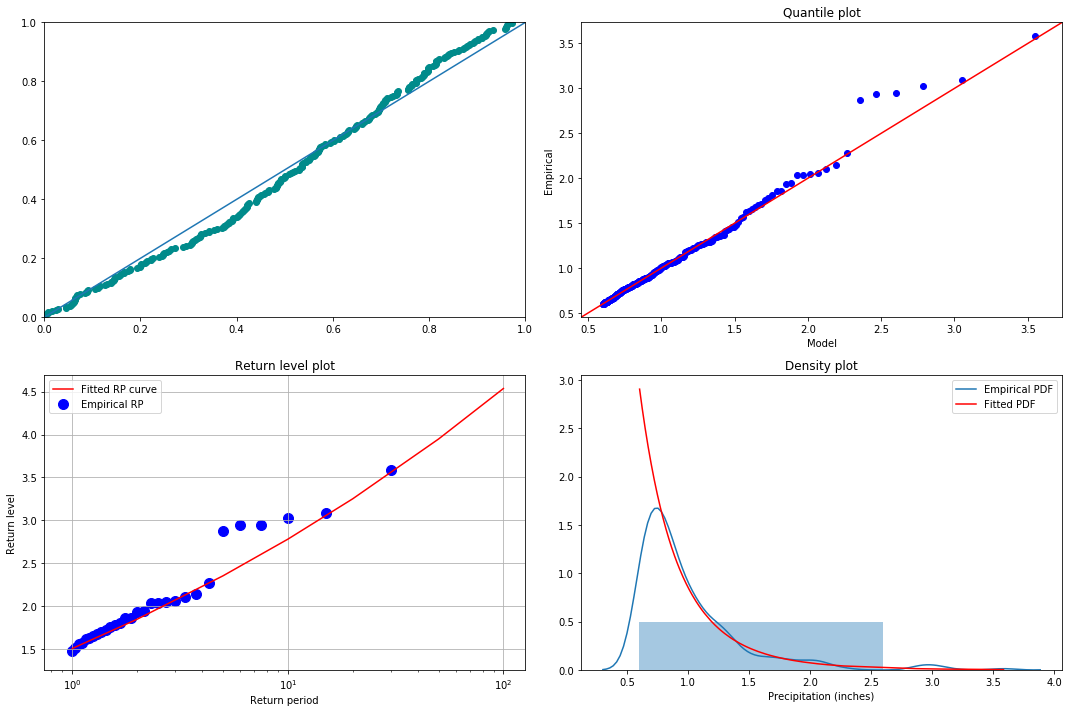

In [80]:
plotDiagnostics(PDS, 0.6, xi, sigma)

In [44]:
def plotFit(data, mu, xi, sigma, title='Return Levels'):
    """
    Plot a fitted distribution, with approximate 90% confidence interval
    and empirical return period values.
    :param data: :class:`numpy.ndarray` of observed data values.
    :param float mu: Selected threshold value.
    :param float xi: Fitted shape parameter.
    :param float sigma: Fitted scale parameter.
    :param str title: Title string for the plot.
    :param str figfile: Path to store the file (includes image format)
    """
    LOG.info("Plotting fitted return period curve")

    rp = np.array([2, 5, 10, 20, 50, 100])
    rate = float(len(data[data > mu])) / float(len(data))
    rval = returnLevels(rp, mu, xi, sigma, rate)

    emprp = empReturnPeriod(data)
    err = returnPeriodUncertainty(data, mu, xi, sigma, rp)

    sortedmax = np.sort(data)
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
    ax1.semilogx(rp, rval, label="Fitted RP curve")
    ax1.semilogx(rp, rval + 1.96 * err, label="95% CI",
                 linestyle='--', color='0.5')
    ax1.semilogx(rp, rval - 1.96 * err, linestyle='--', color='0.5')

    ax1.scatter(emprp[emprp > 1], sortedmax[emprp > 1], s=100,
                color='r', label="Empirical RP")

    title_str = (title + "\n" +
                 r"$\mu$ = {0:.2f}, $\xi$ = {1:.5f}, $\sigma$ = {2:.4f}, $\rho$ = {3:.4f}".
                 format(mu, xi, sigma, rate))
    ax1.set_title(title_str)
    ax1.legend(loc=2)
    ax1.set_ylim((0, 10))
    ax1.set_xlim((1, 100))
    ax1.set_ylabel('Precipitation (inches)')
    ax1.set_xlabel('Return period (years)')
    ax1.grid(which='major')
    ax1.grid(which='minor', linestyle='--', linewidth=1)
    
    # Get Return Levels (precipitation values) for Return Periods
    print('Return Levels:')
    for idx, val in enumerate(rp):
        ci_95 = rval[idx] + 1.96 * err[idx]
        ci_05 = rval[idx] - 1.96 * err[idx]
        print('{}-year Return Level = '.format(val), rval[idx], '({}-{})'.format(ci_05, ci_95))

/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


covaraiance [[ 1.43727306e-03 -2.10221398e-04]
 [-2.10221398e-04  9.30806933e-05]]
Return Levels:
2-year Return Level =  1.8491094069772442 (1.716963832619339-1.9812549813351494)
5-year Return Level =  2.3540588517597 (2.1159257723020866-2.592191931217313)
10-year Return Level =  2.781224469967597 (2.432537319960193-3.1299116199750014)
20-year Return Level =  3.251691223072054 (2.761149637267346-3.7422328088767616)
50-year Return Level =  3.9475885071830534 (3.2122622155748886-4.682914798791218)
100-year Return Level =  4.536287824803929 (3.564373823944402-5.5082018256634555)


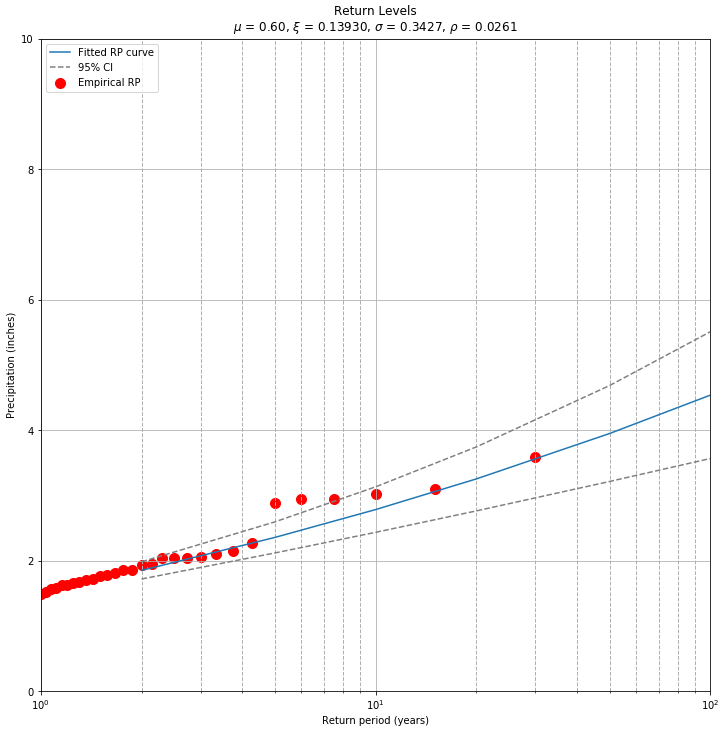

In [45]:
plotFit(PDS, 0.6, xi, sigma)

Code from EVA package

In [ ]:
#' GPD Return Level Estimate and Confidence Interval for Stationary Models
#'
#' Computes stationary m-period return level estimate and interval for the Generalized Pareto distribution,
#' using either the delta method or profile likelihood.
#'
#' @param z An object of class `gpdFit'.
#' @param period The number of periods to use for the return level.
#' @param conf Confidence level. Defaults to 95 percent.
#' @param method The method to compute the confidence interval - either delta method (default) or profile likelihood.
#' @param plot Plot the profile likelihood and estimate (vertical line)?
#' @param opt Optimization method to maximize the profile likelihood if that is selected. Argument passed to optim. The
#' default method is Nelder-Mead.
#'
#' @references Coles, S. (2001). An introduction to statistical modeling of extreme values (Vol. 208). London: Springer.
#' @examples
#' x <- rgpd(5000, loc = 0, scale = 1, shape = -0.1)
#' ## Compute 50-period return level.
#' z <- gpdFit(x, nextremes = 200)
#' gpdRl(z, period = 50, method = "delta")
#' gpdRl(z, period = 50, method = "profile")
#' @return
#' \item{Estimate}{Estimated m-period return level.}
#' \item{CI}{Confidence interval for the m-period return level.}
#' \item{Period}{The period length used.}
#' \item{ConfLevel}{The confidence level used.}
#' @details Caution: The profile likelihood optimization may be slow for large datasets.
#' @export
def gpdRl(z, period, conf = .95, method = "delta", plot = TRUE, opt = "Nelder-Mead"):
    m = period * npp
    est = z.threshold + (z$par.ests[1] / z$par.ests[2]) * ((m * z$rate)^z$par.ests[2] - 1)

In [29]:
#data - Data should be a numeric vector from the GPD.
#threshold - A threshold value or vector of the same length as the data.
#npp - Length of each period (typically year). Is used in return level estimation. Defaults to 365.
# par_ests - parameter estimates   
def generate_eva_parameters(data, mu, xi, sigma):
    n = len(data)
    exceedtrue = data > threshold
    exceedances = data[exceedtrue]
    excess = (data - threshold)[exceedtrue]
    Nu = len(excess)
    p_less_thresh = 1 - Nu/n
    
    return {
        'threshold': threshold,
        'par_ests': [sigma, xi],
        'rate': 1 - p_less_thresh,
        #'varcov': varcov,
        'n': n,
        'data': data,
        'npp': 365,
    }

In [30]:
z = generate_eva_parameters(PDS, 0.6, xi, sigma)
z

{'data': array([0., 0., 0., ..., 0., 0., 0.]),
 'n': 10957,
 'par_ests': [0.34266135541621423, 0.13929724256297166],
 'rate': 0.02610203522862098,
 'threshold': 0.6}

In [74]:
# Code from https://stackoverflow.com/questions/31206443/numpy-second-derivative-of-a-ndimensional-array

def hessian(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x) 
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
    return hessian

x = np.array([2., 4., 9.])
hessian(x)

array([[[-6.04385770e-06, -7.37924086e-06, -1.20712120e-05]]])

In [ ]:
# Code from https://github.com/kikocorreoso/scikit-extremes/blob/master/skextremes/models/classic.py

def nnlf(data, theta):
    # This is used to calculate the variance-covariance matrix using the
    # Hessian from numdifftools

    x = data

    # Here we provide code for the GEV distribution and for the special
    # case when shape parameter is 0 (Gumbel distribution).
    if len(theta) == 3:
        c = theta[0]
        loc = theta[1]
        scale = theta[2]
    if len(theta) == 2:
        c = 0
        loc = theta[0]
        scale = theta[1]
    if c != 0:
        expr = 1. + c * ((x - loc) / scale)
        return (len(x) * np.log(scale) + 
               (1. + 1. / c) * np.sum(np.log(expr)) +
               np.sum(expr ** (-1. / c)))
    else:
        expr = (x - loc) / scale
        return (len(x) * np.log(scale) + 
               np.sum(expr) +
               np.sum(_np.exp(-expr)))

In [72]:
 np.gradient(x)

array([ 0.72996374,  1.01570296, -0.56573433, -1.38176112,  0.67498769,
        0.37001455, -0.2390169 , -0.27212416,  0.29788018,  1.60253258])